# XAI Tutorial 3: Saliency Maps

## Overview
In this tutorial, we will discuss the following topics:
* [Saliency Maps](#tx03saliency)
    * [With Traces](#tx03with)
    * [Without Traces](#tx03without)

We'll start by getting the imports out of the way:

In [1]:
import tempfile
import os

import fastestimator as fe
from fastestimator.architecture.tensorflow import LeNet
from fastestimator.backend import squeeze
from fastestimator.dataset.data import cifair10
from fastestimator.op.numpyop.meta import Sometimes
from fastestimator.op.numpyop.multivariate import HorizontalFlip, PadIfNeeded, RandomCrop
from fastestimator.op.numpyop.univariate import CoarseDropout, Normalize
from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.model import ModelOp, UpdateOp
from fastestimator.schedule import RepeatScheduler
from fastestimator.trace.io import BestModelSaver, ImageViewer
from fastestimator.trace.metric import MCC
from fastestimator.trace.xai import Saliency
from fastestimator.util import to_number

import matplotlib.pyplot as plt
import numpy as np

label_mapping = {
    'airplane': 0,
    'automobile': 1,
    'bird': 2,
    'cat': 3,
    'deer': 4,
    'dog': 5,
    'frog': 6,
    'horse': 7,
    'ship': 8,
    'truck': 9
}

<a id='tx03saliency'></a>

## Saliency Maps

Suppose you have a neural network that is performing image classification. The network tells you that the image it is looking at is an airplane, but you want to know whether it is really detecting an airplane, or if it is 'cheating' by noticing the blue sky in the image background. To answer this question, all you need to do is add the `Saliency` `Trace` to your list of traces, and pass its output to one of either the `ImageSaver`, `ImageViewer`, or `TensorBoard` `Traces`.

<a id='tx03with'></a>

In [2]:
batch_size=128
save_dir = tempfile.mkdtemp()

train_data, eval_data = cifair10.load_data()
test_data = eval_data.split(range(len(eval_data) // 2))
pipeline = fe.Pipeline(
    train_data=train_data,
    eval_data=eval_data,
    test_data=test_data,
    batch_size=batch_size,
    ops=[Normalize(inputs="x", outputs="x", mean=(0.4914, 0.4822, 0.4465), std=(0.2471, 0.2435, 0.2616)),
         PadIfNeeded(min_height=40, min_width=40, image_in="x", image_out="x", mode="train"),
         RandomCrop(32, 32, image_in="x", image_out="x", mode="train"),
         Sometimes(HorizontalFlip(image_in="x", image_out="x", mode="train")),
         CoarseDropout(inputs="x", outputs="x", mode="train", max_holes=1),
         ],
    num_process=0)

model = fe.build(model_fn=lambda: LeNet(input_shape=(32, 32, 3)), optimizer_fn="adam")
network = fe.Network(ops=[
    ModelOp(model=model, inputs="x", outputs="y_pred"),
    CrossEntropy(inputs=("y_pred", "y"), outputs="ce"),
    UpdateOp(model=model, loss_name="ce")
])

traces = [
    MCC(true_key="y", pred_key="y_pred"),
    BestModelSaver(model=model, save_dir=save_dir, metric="mcc", save_best_mode="max", load_best_final=True),
    RepeatScheduler([Saliency(model=model,
                             model_inputs="x",
                             class_key="y",
                             model_outputs="y_pred",
                             samples=5,
                             label_mapping=label_mapping),
                     None, None, None, None]),  # Only compute Saliency every 5 epochs for cleaner logs
    RepeatScheduler([ImageViewer(inputs="saliency"), None, None, None, None])  # Only display the images every 5 epochs for cleaner logs
]
estimator = fe.Estimator(pipeline=pipeline,
                         network=network,
                         epochs=21,
                         traces=traces,
                         log_steps=300)

In this example we will be using the `ImageViewer` `Trace`, since it will allow us to visualize the outputs within this Notebook. If you wanted your images to appear in TensorBoard, simply construct a `TensorBoard` `Trace` with the "write_images" argument set to "saliency". 

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; logging_interval: 300; num_device: 0;
FastEstimator-Train: step: 1; ce: 2.2934406;
FastEstimator-Train: step: 300; ce: 1.5457526; steps/sec: 14.29;
FastEstimator-Train: step: 391; epoch: 1; epoch_time: 28.86 sec;
FastEstimator-BestModelSaver: Saved model to /var/folders/3r/h9kh47050gv6rbt_pgf8cl540000gn/T/tmp0l5yvf_j/model_best_mcc.h5


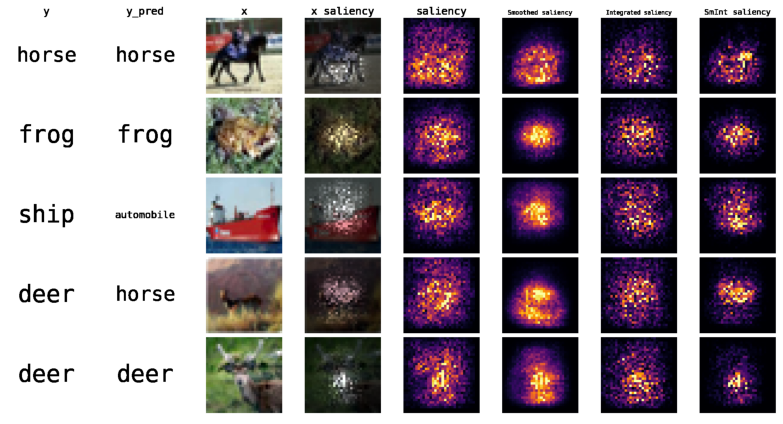

FastEstimator-Eval: step: 391; epoch: 1; ce: 1.4045807; max_mcc: 0.4362919712405745; mcc: 0.4362919712405745; since_best_mcc: 0;
FastEstimator-Train: step: 600; ce: 1.2772174; steps/sec: 14.33;
FastEstimator-Train: step: 782; epoch: 2; epoch_time: 26.76 sec;
FastEstimator-BestModelSaver: Saved model to /var/folders/3r/h9kh47050gv6rbt_pgf8cl540000gn/T/tmp0l5yvf_j/model_best_mcc.h5
FastEstimator-Eval: step: 782; epoch: 2; ce: 1.1574019; max_mcc: 0.5380200647804041; mcc: 0.5380200647804041; since_best_mcc: 0;
FastEstimator-Train: step: 900; ce: 1.134806; steps/sec: 14.67;
FastEstimator-Train: step: 1173; epoch: 3; epoch_time: 27.44 sec;
FastEstimator-BestModelSaver: Saved model to /var/folders/3r/h9kh47050gv6rbt_pgf8cl540000gn/T/tmp0l5yvf_j/model_best_mcc.h5
FastEstimator-Eval: step: 1173; epoch: 3; ce: 1.0939687; max_mcc: 0.5779503699431809; mcc: 0.5779503699431809; since_best_mcc: 0;
FastEstimator-Train: step: 1200; ce: 1.1082952; steps/sec: 14.0;
FastEstimator-Train: step: 1500; ce: 0.

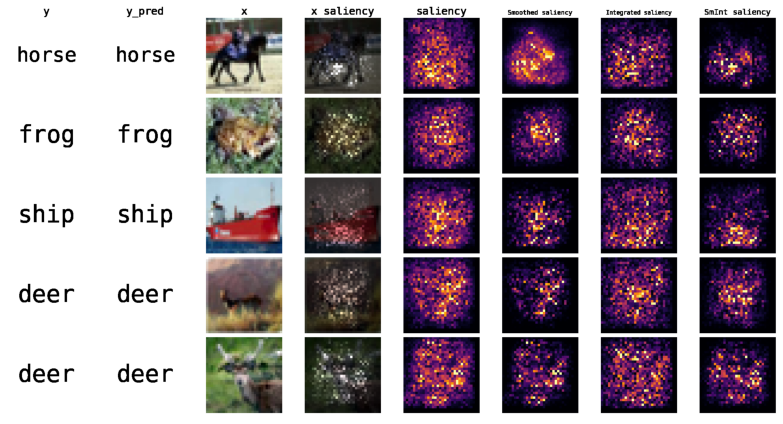

FastEstimator-Eval: step: 2346; epoch: 6; ce: 0.9100213; max_mcc: 0.6482139497233522; mcc: 0.6482139497233522; since_best_mcc: 0;
FastEstimator-Train: step: 2400; ce: 1.0204352; steps/sec: 13.42;
FastEstimator-Train: step: 2700; ce: 0.9631138; steps/sec: 13.06;
FastEstimator-Train: step: 2737; epoch: 7; epoch_time: 29.39 sec;
FastEstimator-BestModelSaver: Saved model to /var/folders/3r/h9kh47050gv6rbt_pgf8cl540000gn/T/tmp0l5yvf_j/model_best_mcc.h5
FastEstimator-Eval: step: 2737; epoch: 7; ce: 0.89615554; max_mcc: 0.6527592334445234; mcc: 0.6527592334445234; since_best_mcc: 0;
FastEstimator-Train: step: 3000; ce: 0.9801494; steps/sec: 12.13;
FastEstimator-Train: step: 3128; epoch: 8; epoch_time: 32.01 sec;
FastEstimator-BestModelSaver: Saved model to /var/folders/3r/h9kh47050gv6rbt_pgf8cl540000gn/T/tmp0l5yvf_j/model_best_mcc.h5
FastEstimator-Eval: step: 3128; epoch: 8; ce: 0.85927296; max_mcc: 0.6647843529454457; mcc: 0.6647843529454457; since_best_mcc: 0;
FastEstimator-Train: step: 330

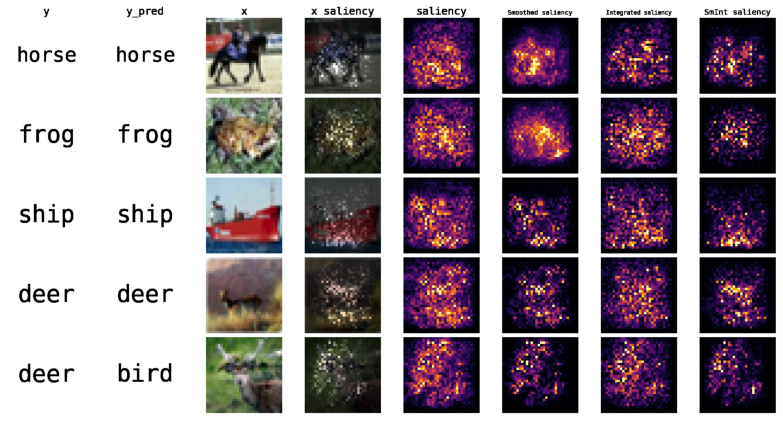

FastEstimator-Eval: step: 4301; epoch: 11; ce: 0.7567305; max_mcc: 0.6988702613092561; mcc: 0.6988702613092561; since_best_mcc: 0;
FastEstimator-Train: step: 4500; ce: 0.8491746; steps/sec: 14.44;
FastEstimator-Train: step: 4692; epoch: 12; epoch_time: 27.09 sec;
FastEstimator-BestModelSaver: Saved model to /var/folders/3r/h9kh47050gv6rbt_pgf8cl540000gn/T/tmp0l5yvf_j/model_best_mcc.h5
FastEstimator-Eval: step: 4692; epoch: 12; ce: 0.7384265; max_mcc: 0.7161156434711551; mcc: 0.7161156434711551; since_best_mcc: 0;
FastEstimator-Train: step: 4800; ce: 0.91482806; steps/sec: 14.02;
FastEstimator-Train: step: 5083; epoch: 13; epoch_time: 27.72 sec;
FastEstimator-Eval: step: 5083; epoch: 13; ce: 0.72497606; max_mcc: 0.7161156434711551; mcc: 0.7123381750154947; since_best_mcc: 1;
FastEstimator-Train: step: 5100; ce: 0.9652822; steps/sec: 14.07;
FastEstimator-Train: step: 5400; ce: 0.7621952; steps/sec: 13.97;
FastEstimator-Train: step: 5474; epoch: 14; epoch_time: 28.1 sec;
FastEstimator-Eva

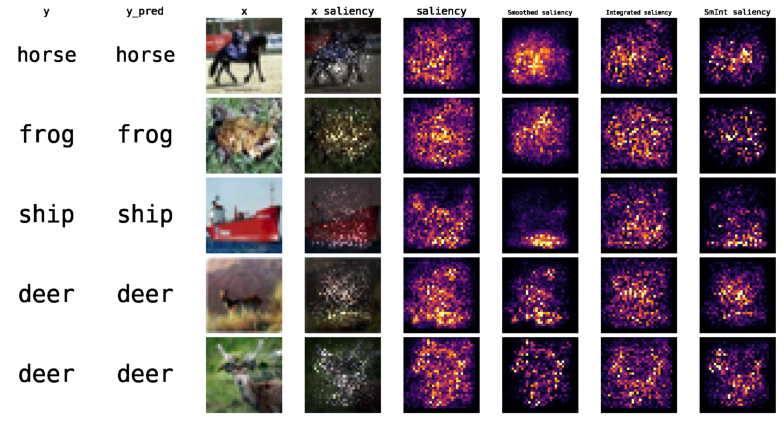

FastEstimator-Eval: step: 6256; epoch: 16; ce: 0.7153445; max_mcc: 0.7318416778408738; mcc: 0.7318416778408738; since_best_mcc: 0;
FastEstimator-Train: step: 6300; ce: 0.83881253; steps/sec: 14.29;
FastEstimator-Train: step: 6600; ce: 0.7533579; steps/sec: 14.1;
FastEstimator-Train: step: 6647; epoch: 17; epoch_time: 27.18 sec;
FastEstimator-Eval: step: 6647; epoch: 17; ce: 0.6973645; max_mcc: 0.7318416778408738; mcc: 0.7298983561892437; since_best_mcc: 1;
FastEstimator-Train: step: 6900; ce: 0.75511664; steps/sec: 14.21;
FastEstimator-Train: step: 7038; epoch: 18; epoch_time: 27.76 sec;
FastEstimator-Eval: step: 7038; epoch: 18; ce: 0.69986886; max_mcc: 0.7318416778408738; mcc: 0.7256185931497982; since_best_mcc: 2;
FastEstimator-Train: step: 7200; ce: 0.7804471; steps/sec: 14.1;
FastEstimator-Train: step: 7429; epoch: 19; epoch_time: 27.78 sec;
FastEstimator-BestModelSaver: Saved model to /var/folders/3r/h9kh47050gv6rbt_pgf8cl540000gn/T/tmp0l5yvf_j/model_best_mcc.h5
FastEstimator-Eva

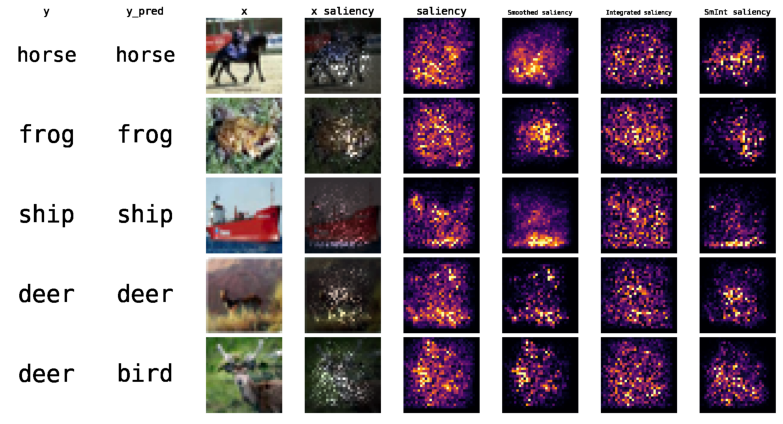

FastEstimator-Eval: step: 8211; epoch: 21; ce: 0.6946831; max_mcc: 0.7328821958763446; mcc: 0.729144989091964; since_best_mcc: 2;
FastEstimator-BestModelSaver: Restoring model from /var/folders/3r/h9kh47050gv6rbt_pgf8cl540000gn/T/tmp0l5yvf_j/model_best_mcc.h5
FastEstimator-Finish: step: 8211; model_lr: 0.001; total_time: 676.16 sec;


In [3]:
estimator.fit()

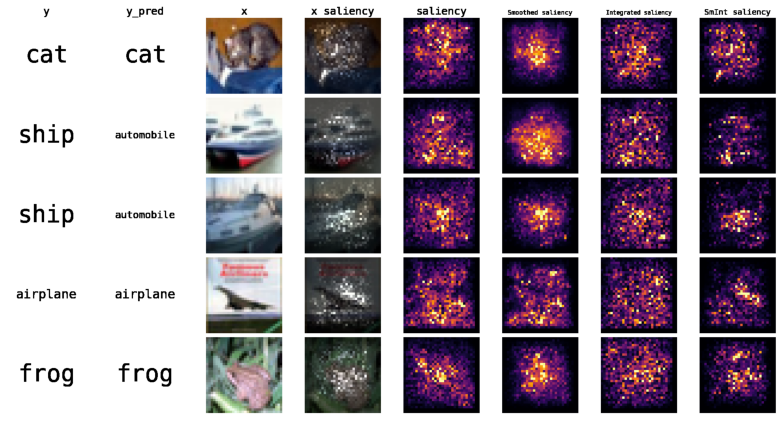

FastEstimator-Test: step: 8211; epoch: 21; ce: 0.7404646; mcc: 0.7284574229572097;


In [4]:
estimator.test()

In the images above, the 'saliency' column corresponds to a raw saliency mask generated by back-propagating a model's output prediction onto the input image. 'Smoothed saliency' combines multiple saliency masks for each image 'x', where each mask is generated by slightly perturbing the input 'x' before running the forward and backward gradient passes. The number of samples to be combined is controlled by the "smoothing" argument in the `Saliency` `Trace` constructor. 'Integrated saliency' is a saliency mask generated by starting from a baseline noise image and linearly interpolating the image towards 'x' over a number of steps defined by the "integrating" argument in the Saliency constructor. The resulting masks are then combined together. The 'SmInt Saliency' (Smoothed-Integrated) column combines smoothing and integration together. SmInt is generally considered to give the most reliable indication of the important features in an image, but it also takes the longest to compute. It is possible to disable the more complex columns by setting the 'smoothing' and 'integrating' parameters to 0. The 'x saliency' column shows the input image overlaid with whatever saliency column is furthest to the right (SmInt, unless that has been disabled).

<a id='tx03without'></a>

## Saliency Maps without Traces

Suppose that you want to generate Saliency masks without using a `Trace`. This can be done through the fe.xai package:

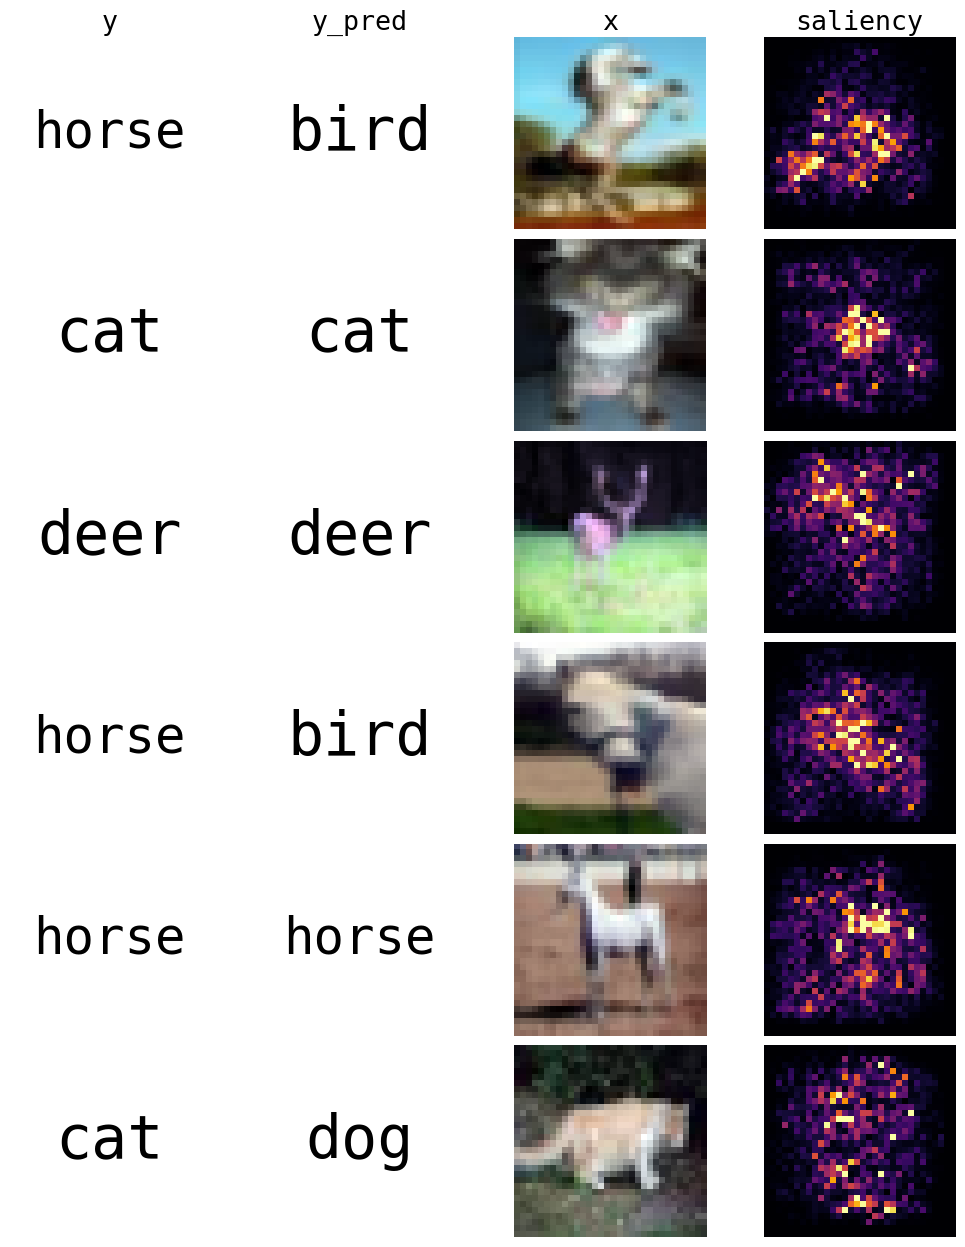

In [5]:
pipeline.batch_size = 6
batch = pipeline.get_results(num_steps=2, mode='eval')[1] # Get some images we didn't see already above
batch = fe.backend.to_tensor(batch, "tf")  # Convert the batch to TensorFlow

saliency_generator = fe.xai.SaliencyNet(model=model, model_inputs="x", model_outputs="y_pred")
images = saliency_generator.get_smoothed_masks(batch=batch, nsamples=6, nintegration=100)

# Let's convert 'y' and 'y_pred' from numeric values to strings for readability:
val_to_label = {val: key for key, val in label_mapping.items()}
y = np.array([val_to_label[clazz] for clazz in to_number(squeeze(batch["y"]))])
y_pred = np.array([val_to_label[clazz] for clazz in to_number(squeeze(images["y_pred"]))])

# Now simply load up an ImgData object and let it handle laying out the final result for you
save_dir = tempfile.mkdtemp()
images = fe.util.ImgData(colormap="inferno", y=y, y_pred=y_pred, x=batch["x"], saliency=images["saliency"])
fig = images.paint_figure(save_path=os.path.join(save_dir, "t08a_saliency.png")) # save_path is optional, but a useful feature to know about
plt.show()

The `SaliencyNet` class also provides 'get_masks' and 'get_integrated_masks' methods for generating other versions of saliency masks. For a detailed overview of various saliency algorithms and their benefits / drawbacks, see https://distill.pub/2020/attribution-baselines/